In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import jax
import jax.numpy as jnp

%matplotlib inline
%config InlineBackend.figure_format="retina"

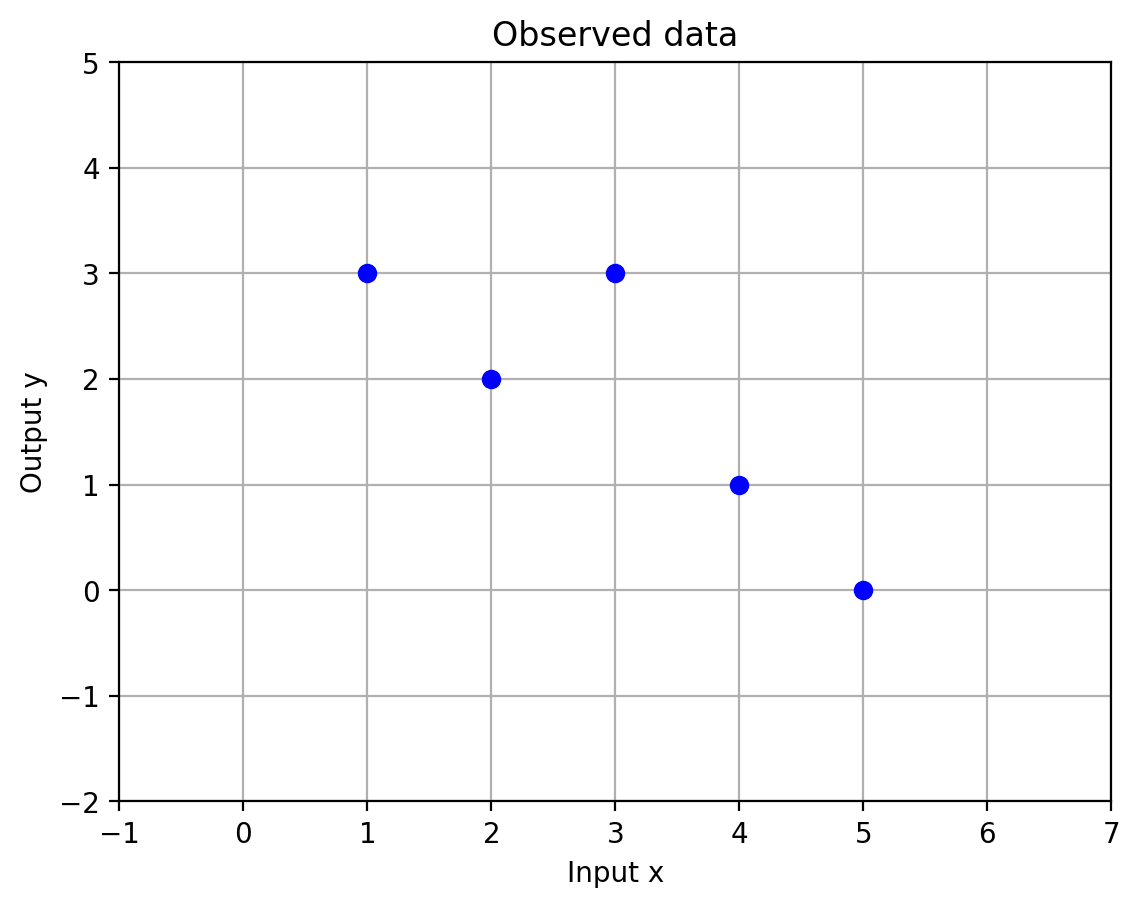

In [2]:
x_data_list = [1, 2, 3, 4, 5]
y_data_list = [3, 2, 3, 1, 0]

def plot_basic_data(parameters_list=None, title="Observed data"):
  xlim = [-1, 7]
  fig, ax = plt.subplots()
  
  if parameters_list is not None:
    x_pred = np.linspace(xlim[0], xlim[1], 100)
    for parameters in parameters_list:
      y_pred = parameters[0] + parameters[1] * x_pred
      ax.plot(x_pred, y_pred, ':', color=[1, 0.7, 0.6])

    parameters = parameters_list[-1]
    y_pred = parameters[0] + parameters[1] * x_pred
    ax.plot(x_pred, y_pred, "-", color=[1, 0, 0], lw=2)

  ax.plot(x_data_list, y_data_list, "ob")
  ax.set(xlabel="Input x", ylabel="Output y",
         title=title,
         xlim=xlim, ylim=[-2, 5])
  ax.grid()

plot_basic_data()

In [3]:
parameters_list = []

Plotting line -0.85 * x + 4.33


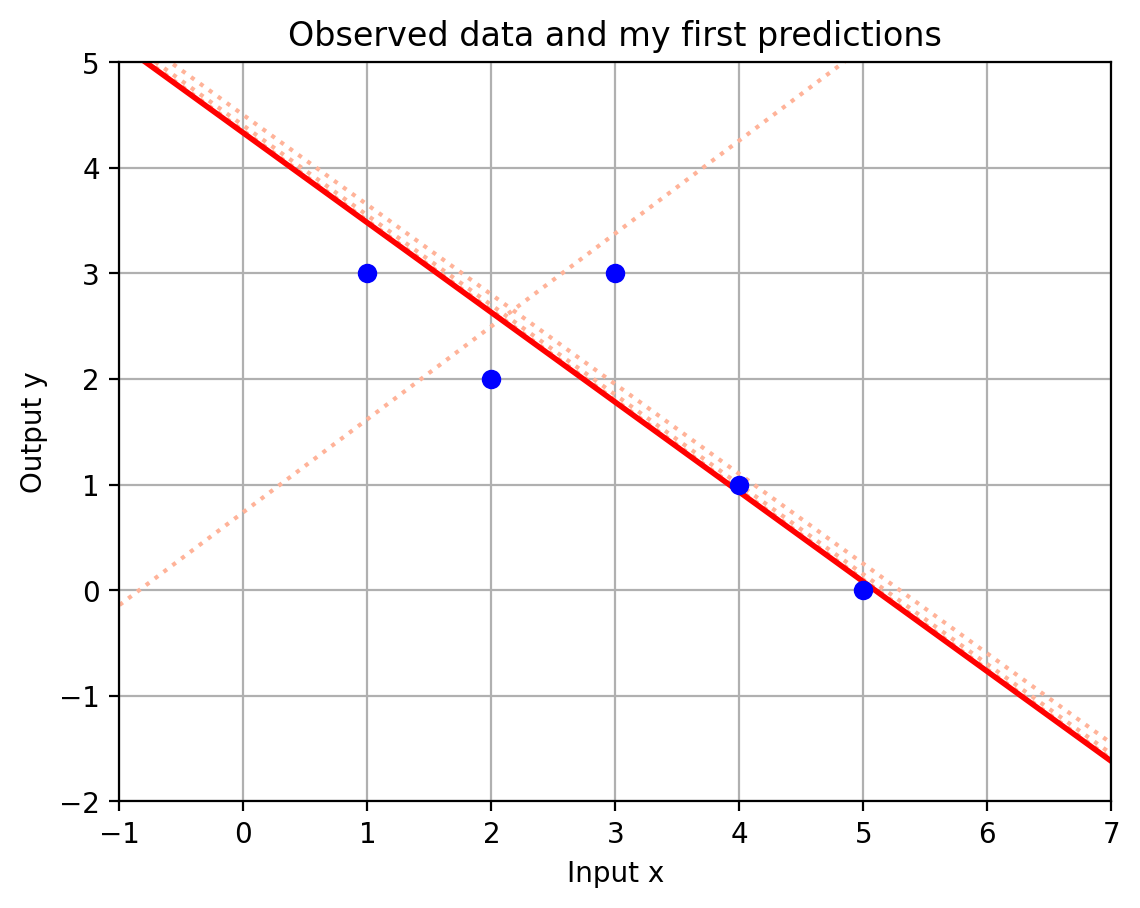

In [8]:
b = 4.33 # Bias
w = -0.85 # Weight
print("Plotting line", w, "* x +", b)
parameters = [b, w]
parameters_list.append(parameters)
plot_basic_data(parameters_list, title="Observed data and my first predictions")

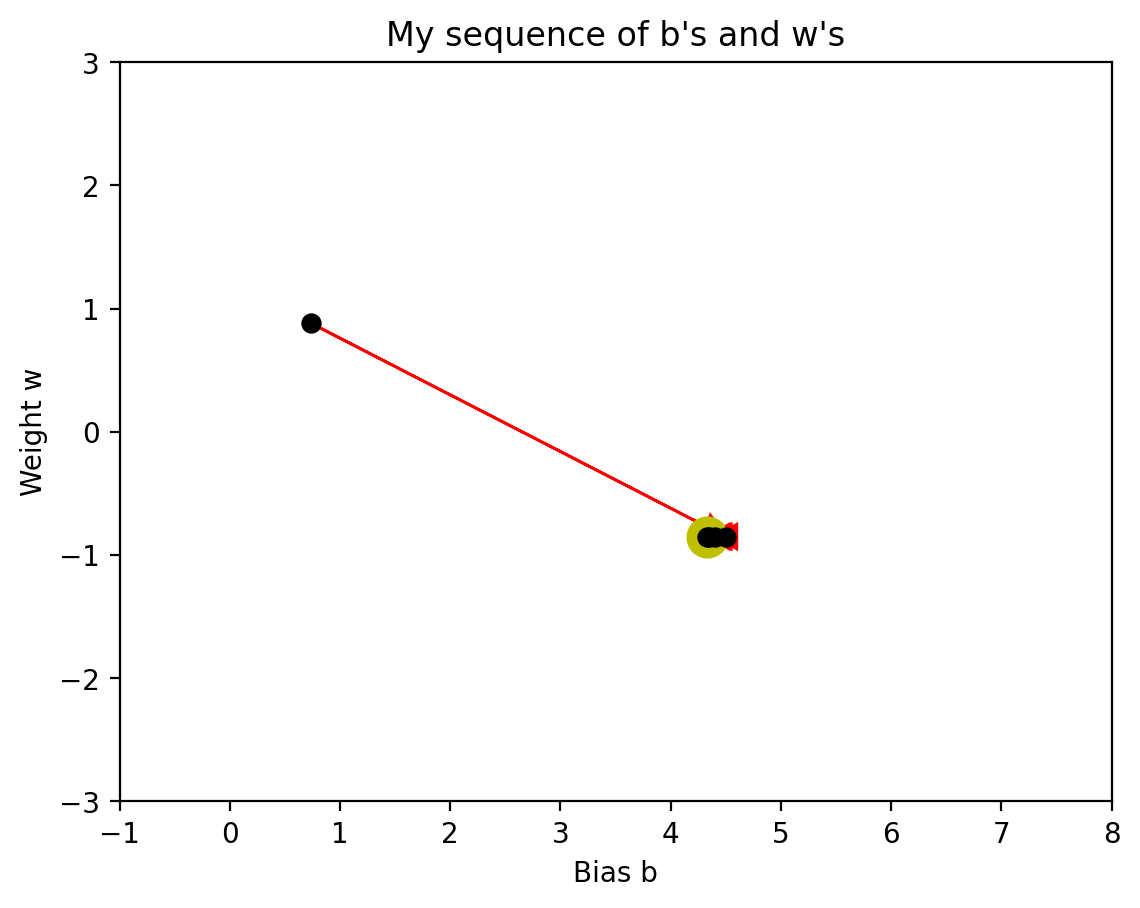

In [9]:
fig, ax = plt.subplots()
opt = {"head_width": 0.2, "head_length": 0.2,
       "length_includes_head": True, "color": "r"}
if parameters_list is not None:
  b_old = parameters_list[0][0]
  w_old = parameters_list[0][1]
  for i in range(1, len(parameters_list)):
    b_next = parameters_list[i][0]
    w_next = parameters_list[i][1]
    ax.arrow(b_old, w_old, b_next - b_old, w_next - w_old, **opt)
    b_old, w_old = b_next, w_next

  ax.scatter(b_old, w_old, s=200, marker="o", color="y")
  bs = [parameters[0] for parameters in parameters_list]
  ws =  [parameters[1] for parameters in parameters_list]
  ax.scatter(bs, ws, s=40, marker='o', color='k')

ax.set(xlabel="Bias b", ylabel="Weight w",
       title="My sequence of b\'s and w\'s",
       xlim=[-1, 8], ylim=[-3, 3])
plt.show()

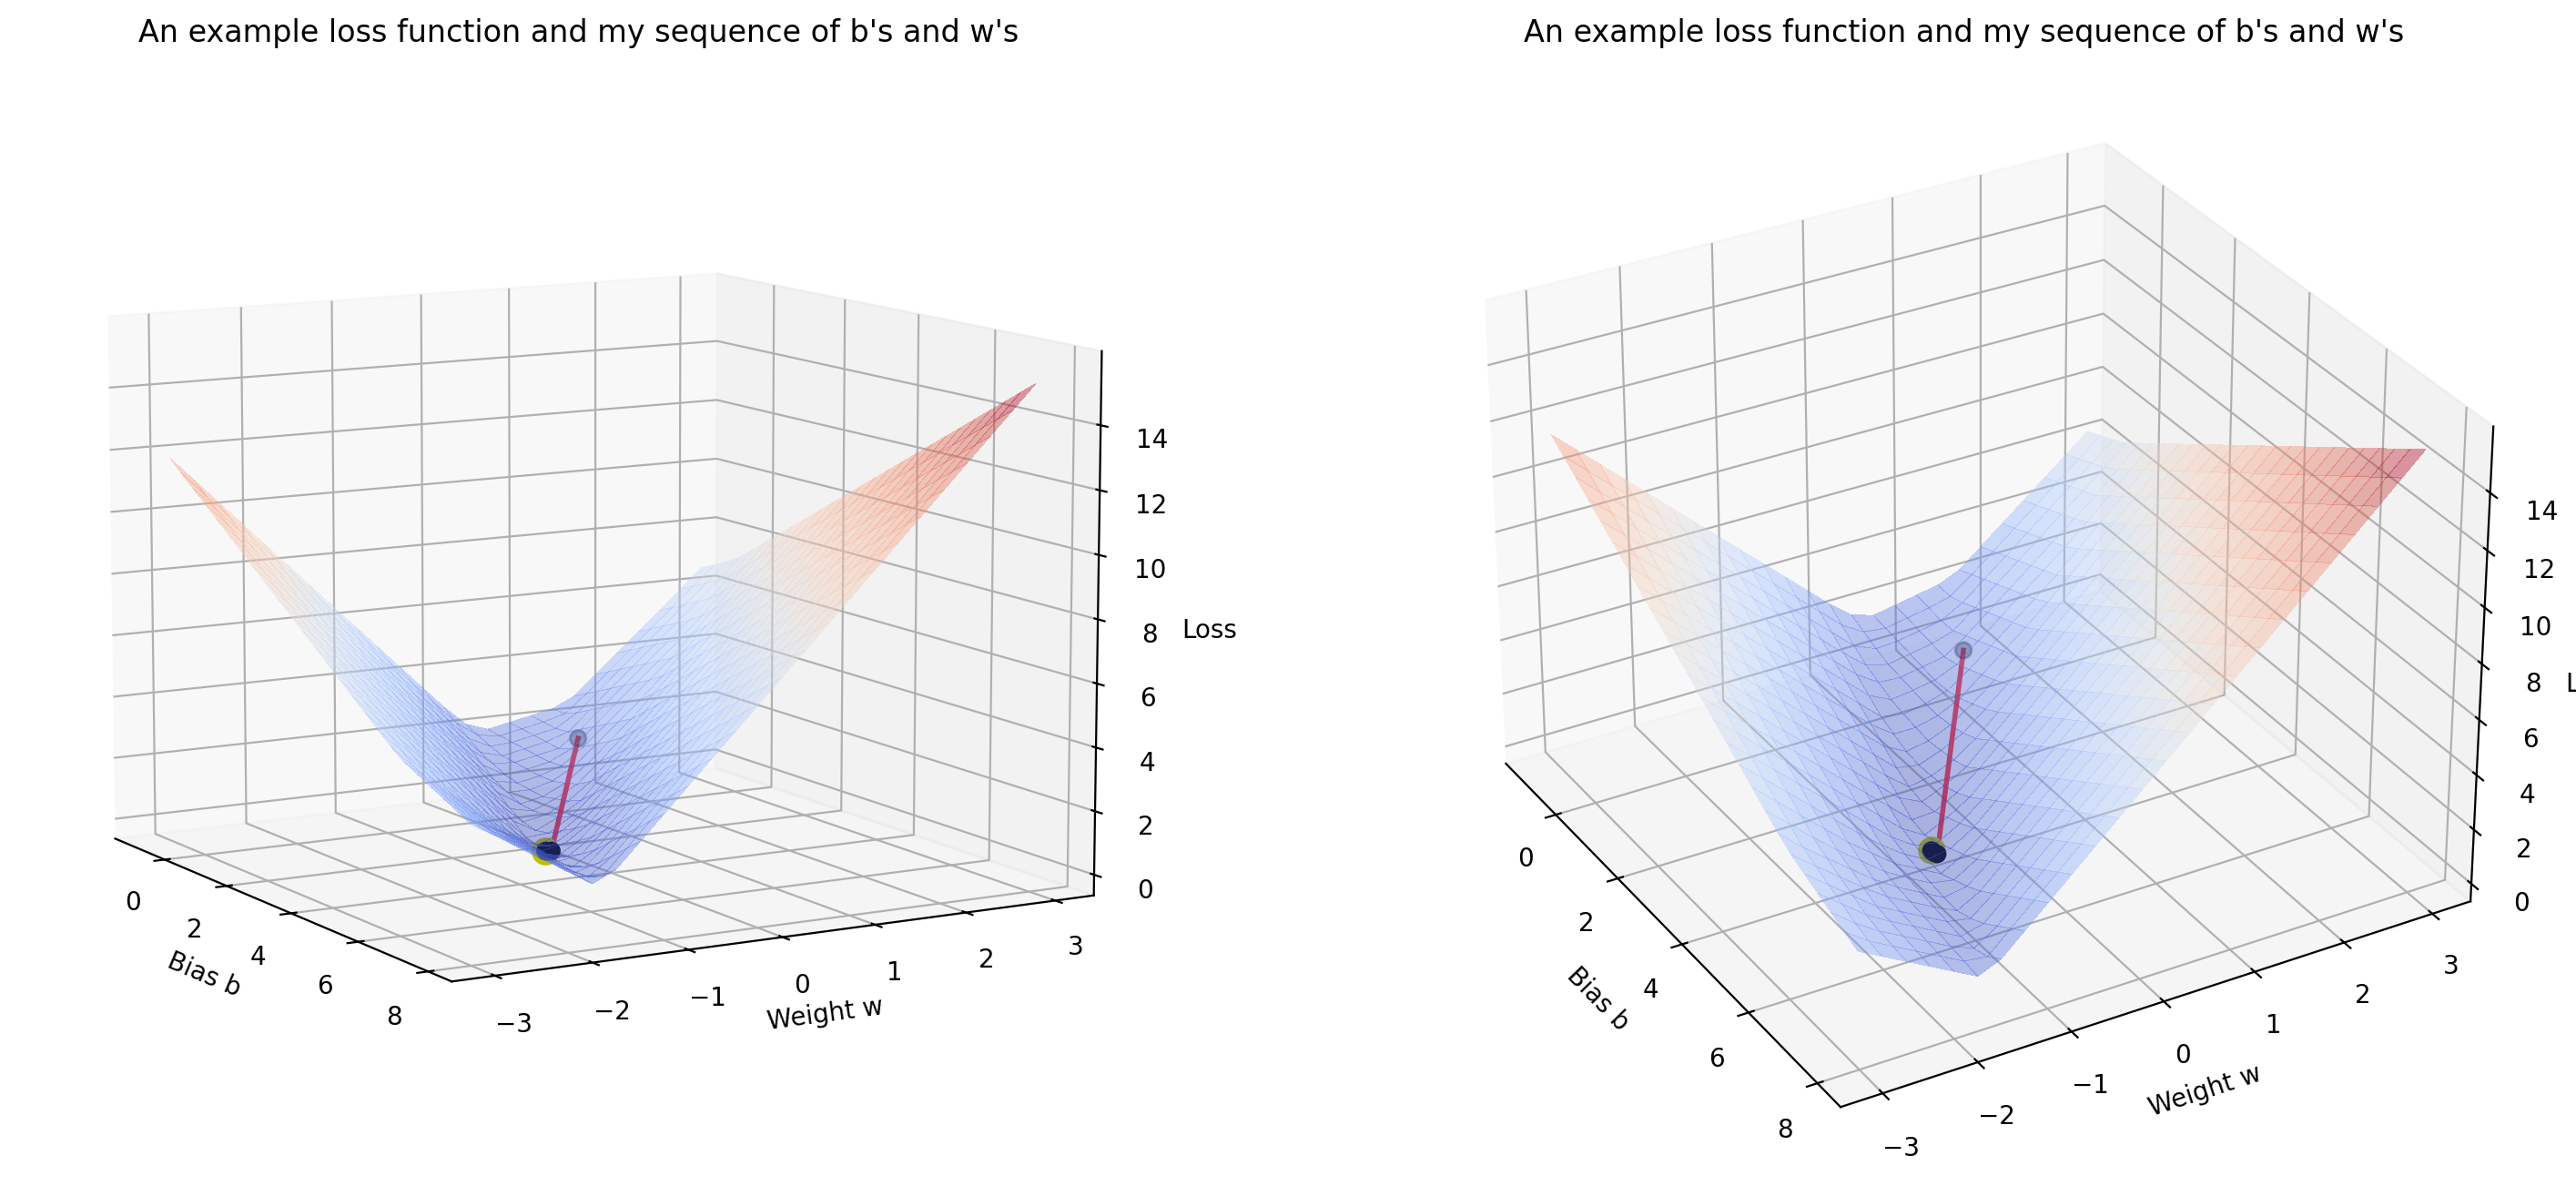

In [14]:
def l1_loss(b, w):
  loss = 0 * b
  for x, y in zip(x_data_list, y_data_list):
    f = w * x + b
    loss += np.abs(f - y)
  return loss / len(x_data_list)

bs, ws = np.linspace(-1, 8, num=25), np.linspace(-3, 3, num=25)
b_grid, w_grid = np.meshgrid(bs, ws)
loss_grid = l1_loss(b_grid, w_grid)

def plot_loss(parameters_list, title, show_stops=False):
  fig, ax = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={"projection": "3d"})
  ax[0].view_init(10, -30)
  ax[1].view_init(30, -30)

  if parameters_list is not None:
    b_old = parameters_list[0][0]
    w_old = parameters_list[0][1]
    loss_old = l1_loss(b_old, w_old)
    ls = [loss_old]

    for i in range(1, len(parameters_list)):
      b_next = parameters_list[i][0]
      w_next = parameters_list[i][1]
      loss_next = l1_loss(b_next, w_next)
      ls.append(loss_next)

      ax[0].plot([b_old, b_next], [w_old, w_next], [loss_old, loss_next], color="red", alpha=0.8, lw=2)
      ax[1].plot([b_old, b_next], [w_old, w_next], [loss_old, loss_next], color="red", alpha=0.8, lw=2)
      b_old, w_old, loss_old = b_next, w_next, loss_next

    if show_stops:
      ax[0].scatter(b_old, w_old, loss_old, s=100, marker="o", color="y")
      ax[1].scatter(b_old, w_old, loss_old, s=100, marker="o", color="y")
      bs = [parameters[0] for parameters in parameters_list]
      ws = [parameters[1] for parameters in parameters_list]
      ax[0].scatter(bs, ws, ls, s=40, marker="o", color="k")
      ax[1].scatter(bs, ws, ls, s=40, marker="o", color="k")
    else:
      ax[0].scatter(b_old, w_old, loss_old, s=40, marker='o', color='k')
      ax[1].scatter(b_old, w_old, loss_old, s=40, marker='o', color='k')

  ax[0].plot_surface(b_grid, w_grid, loss_grid, cmap=cm.coolwarm, linewidth=0, alpha=0.4, antialiased=False)
  ax[1].plot_surface(b_grid, w_grid, loss_grid, cmap=cm.coolwarm, linewidth=0, alpha=0.4, antialiased=False)
  ax[0].set(xlabel="Bias b", ylabel="Weight w", zlabel="Loss", title=title)
  ax[1].set(xlabel="Bias b", ylabel="Weight w", zlabel="Loss", title=title)
  plt.show()

plot_loss(parameters_list, "An example loss function and my sequence of b\'s and w\'s", show_stops=True)

In [15]:
def manual_grad(b, w):
  grad_b = 0
  grad_w = 0
  for x, y in zip(x_data_list, y_data_list):
    f = w * x + b
    grad_b += np.sign(f - y)
    grad_w += np.sign(f - y) * x
  grad_b /= len(x_data_list)
  grad_w /= len(x_data_list)
  return grad_b, grad_w

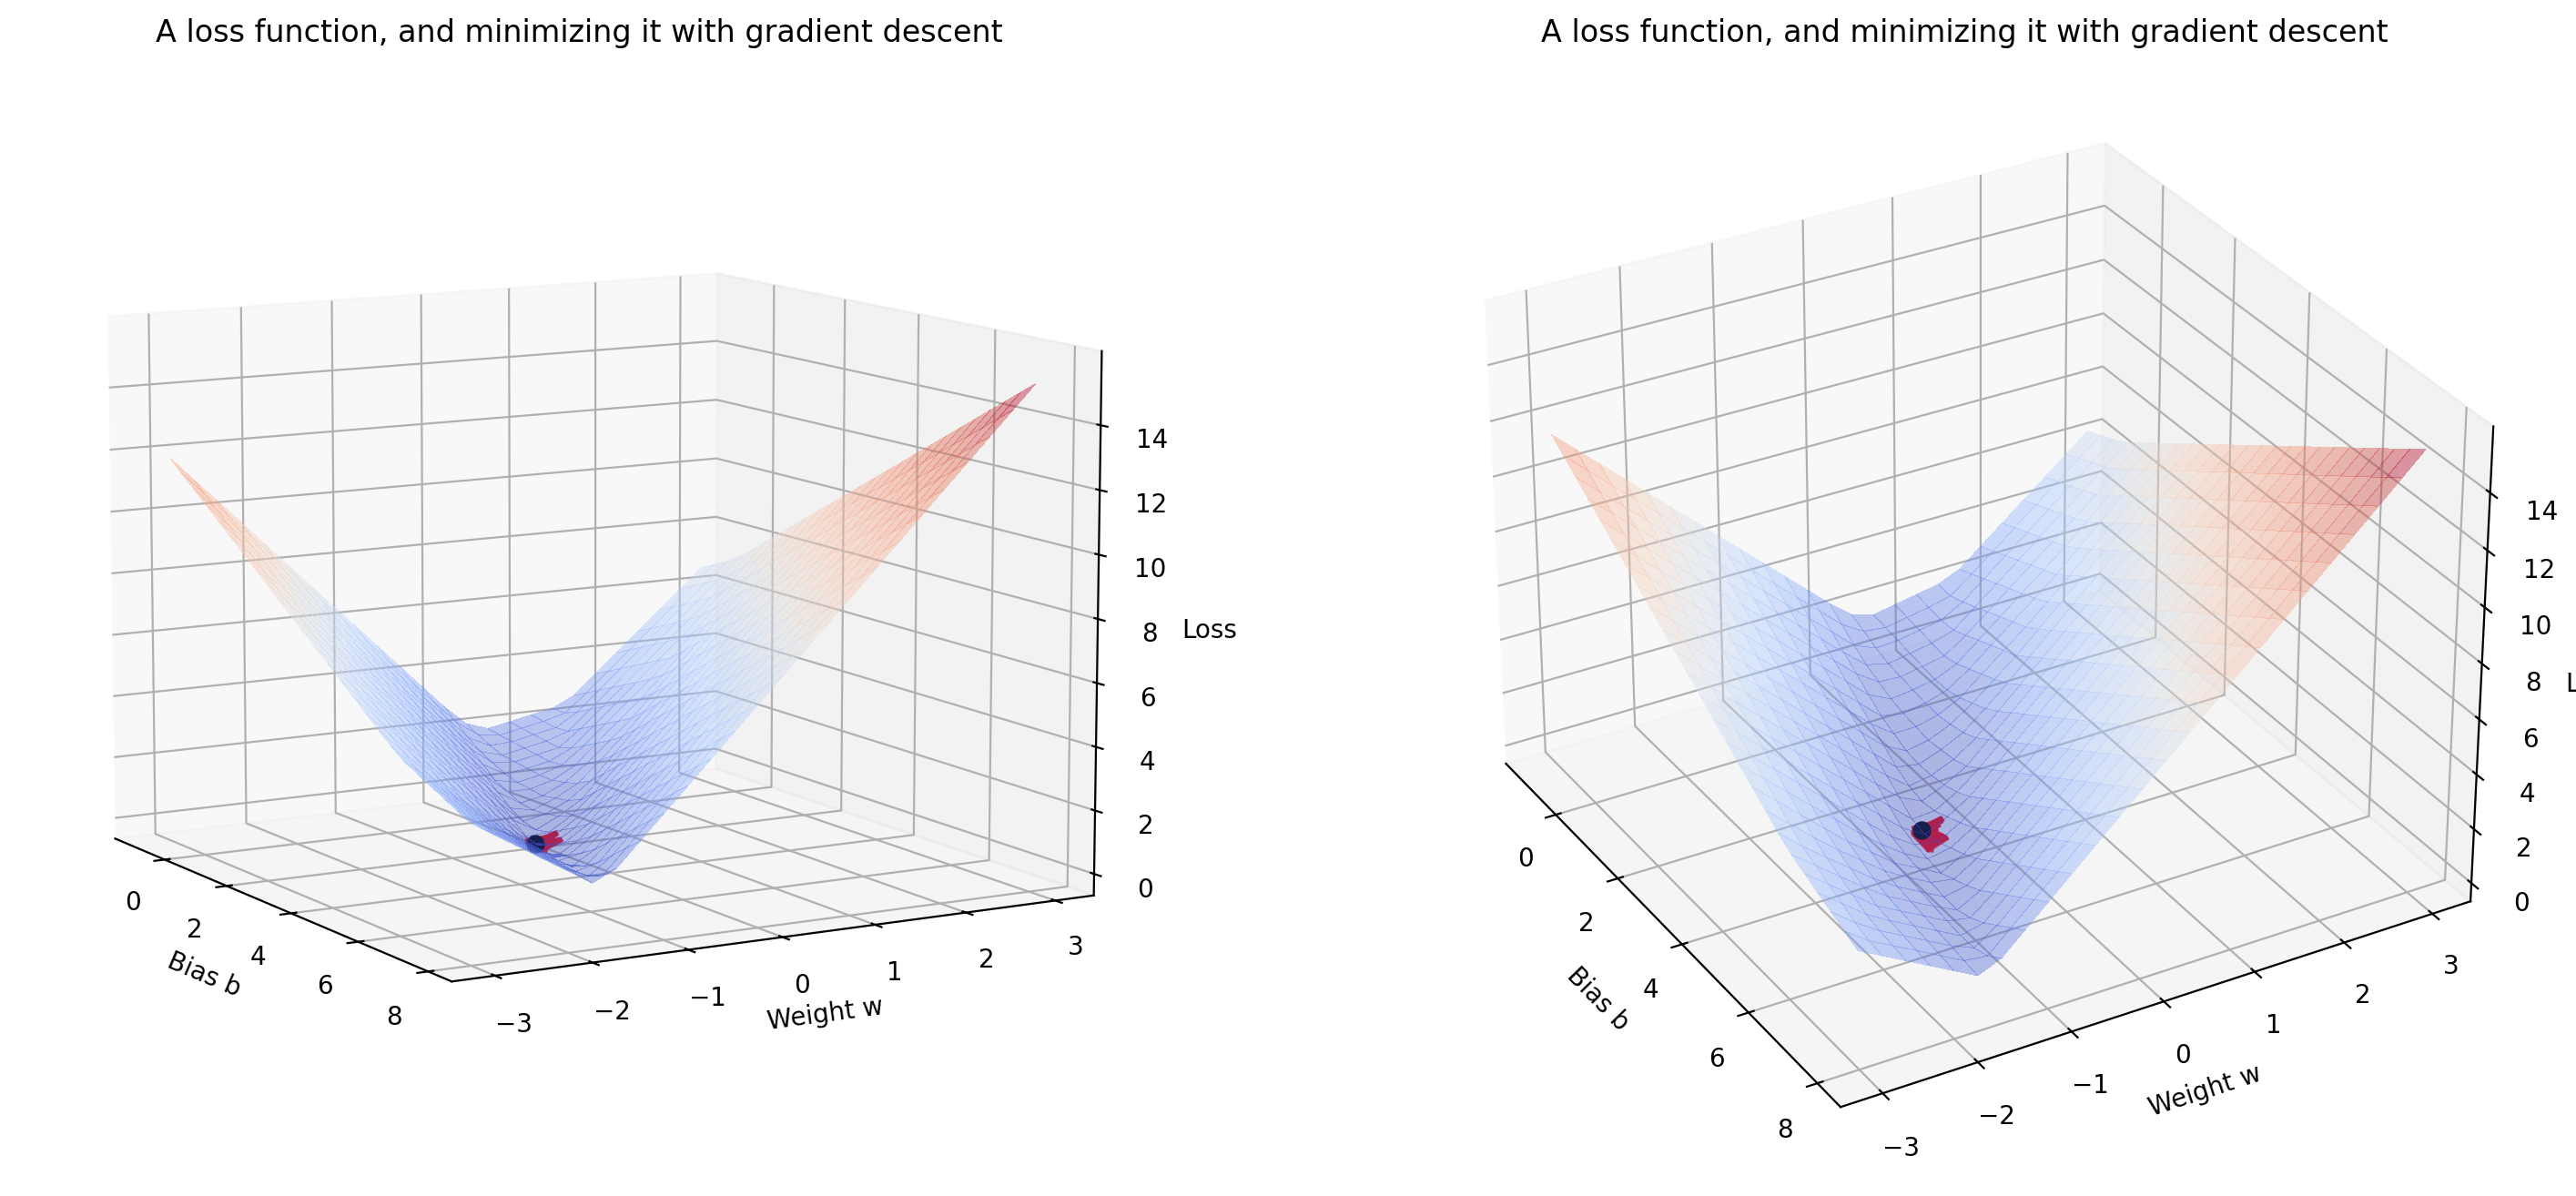

In [16]:
b = 4.33
w = -0.85
learning_rate = 0.1

parameters_step_list = []

for _ in range(200):
  parameters_step_list.append([b, w]) 
  grad_b, grad_w = manual_grad(b, w)
  b = b - learning_rate * grad_b
  w = w - learning_rate * grad_w

plot_loss(parameters_step_list, "A loss function, and minimizing it with gradient descent")

In [17]:
x = np.array(x_data_list)
y = np.array(y_data_list)

def loss_funtion(b, w):
    f = w * x + b
    errors = jnp.abs(f - y)
    return jnp.mean(errors)

auto_grad = jax.grad(loss_funtion, argnums=(0, 1))

b, w = 4.5, -0.85

grad_b, grad_w = auto_grad(b, w)
print("Auto grad:\n", "Grad b:" , grad_b, "\n", "Grad w:" , grad_w)

grad_b, grad_w = manual_grad(b, w)
print("\nManual grad:\n", "Grad b:" , grad_b, "\n", "Grad w:" , grad_w)

Auto grad:
 Grad b: 0.6 
 Grad w: 1.8

Manual grad:
 Grad b: 0.6 
 Grad w: 1.8


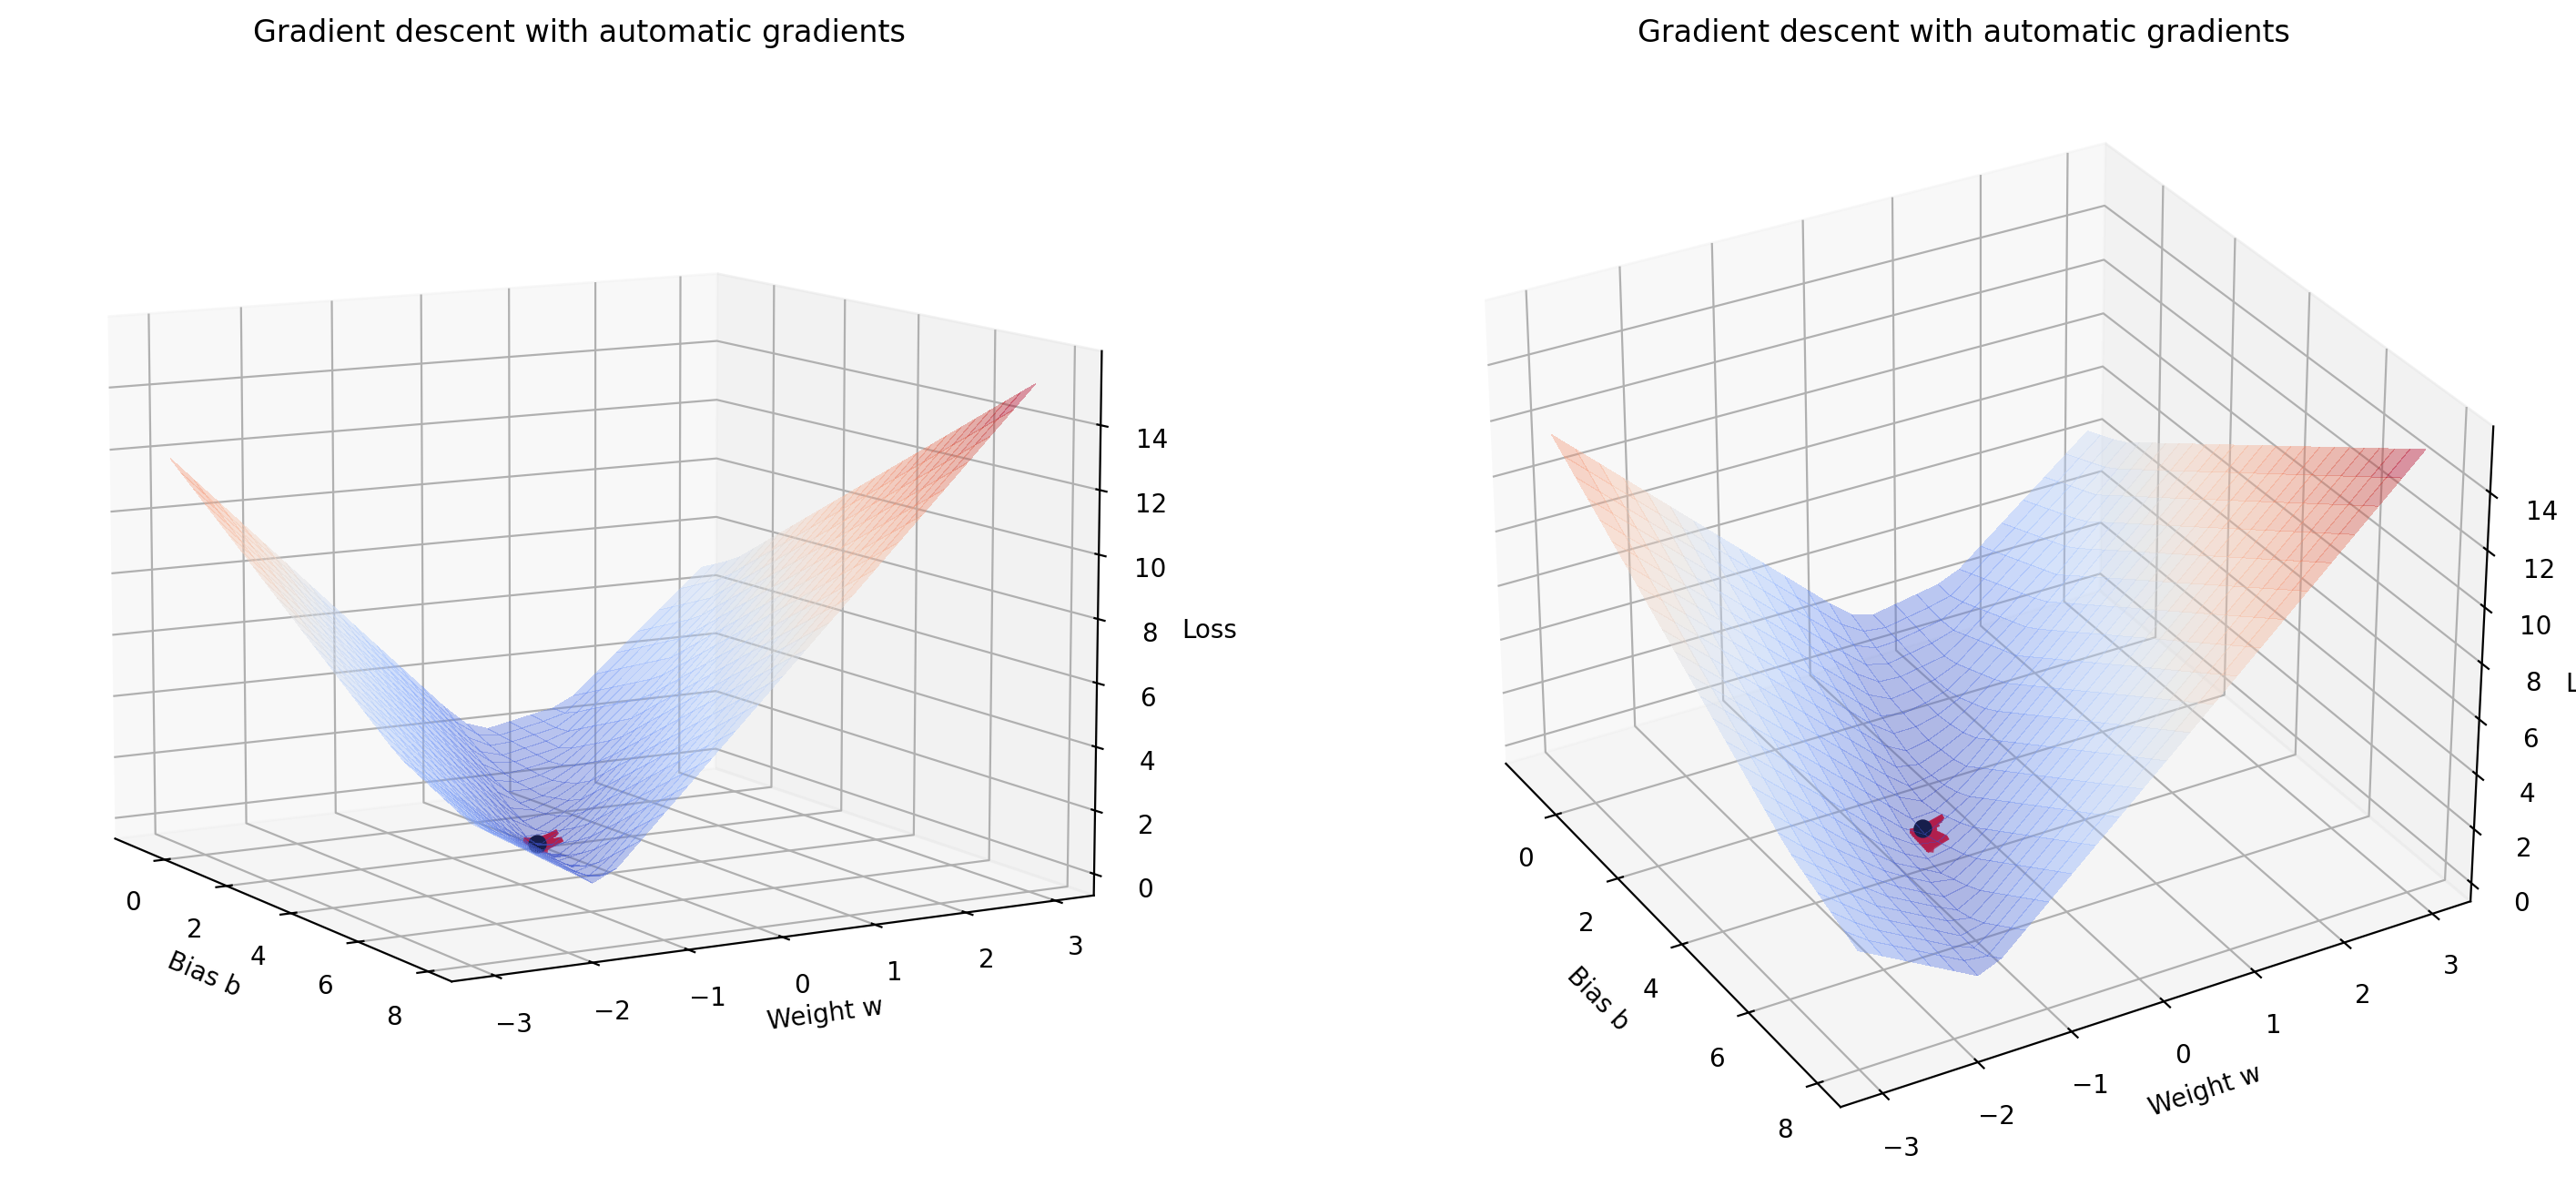

In [19]:
b, w = 4.33, -0.85
learning_rate = 0.1

parameters_step_list = []

for _ in range(200):
    parameters_step_list.append([b, w])
    grad_b, grad_w = auto_grad(b, w)
    b = b -learning_rate * grad_b
    w = w -learning_rate * grad_w

plot_loss(parameters_step_list, "Gradient descent with automatic gradients")

In [21]:
def generate_wave_like_dataset(min_x=-1, max_x=1, n=100):
    xs = np.linspace(min_x, max_x, n)
    ys = np.sin(5 * xs) + np.random.normal(size=len(xs), scale=0.2)
    return xs, ys

def regression_analytical_solution(X, y):
    return ((np.linalg.inv(X.T.dot(X))).dot(X.T)).dot(y)

def gradient_descent(X, y, learning_rate=1e-2, num_steps=1000):
    report_every = num_steps // 10

    def loss(current_w, X, y):
        y_hat = jnp.dot(X, current_w)
        loss = jnp.mean((y_hat - y) ** 2)
        return loss, y_hat

    loss_and_grad = jax.value_and_grad(loss, has_aux=True)
    # Initialize the parameters
    w = np.random.normal(size=(X.shape[1]))

    # Run a a few steps of gradient descent
    for i in range(num_steps):
        (loss, y_hat), grad = loss_and_grad(w, X, ys)

        if i % report_every == 0:
            print(f"Step {i}: w: {w}, Loss: {loss}, Grad: {grad}")

        w = w - learning_rate * grad

    return w

def plot_data(y_hat, xs, ys, title):
    plt.figure()
    plt.scatter(xs, ys, label="Data")
    plt.plot(xs, y_hat, 'r', label=title)

    plt.title(title)
    plt.xlabel("Input x")
    plt.ylabel("Output y")
    plt.legend();

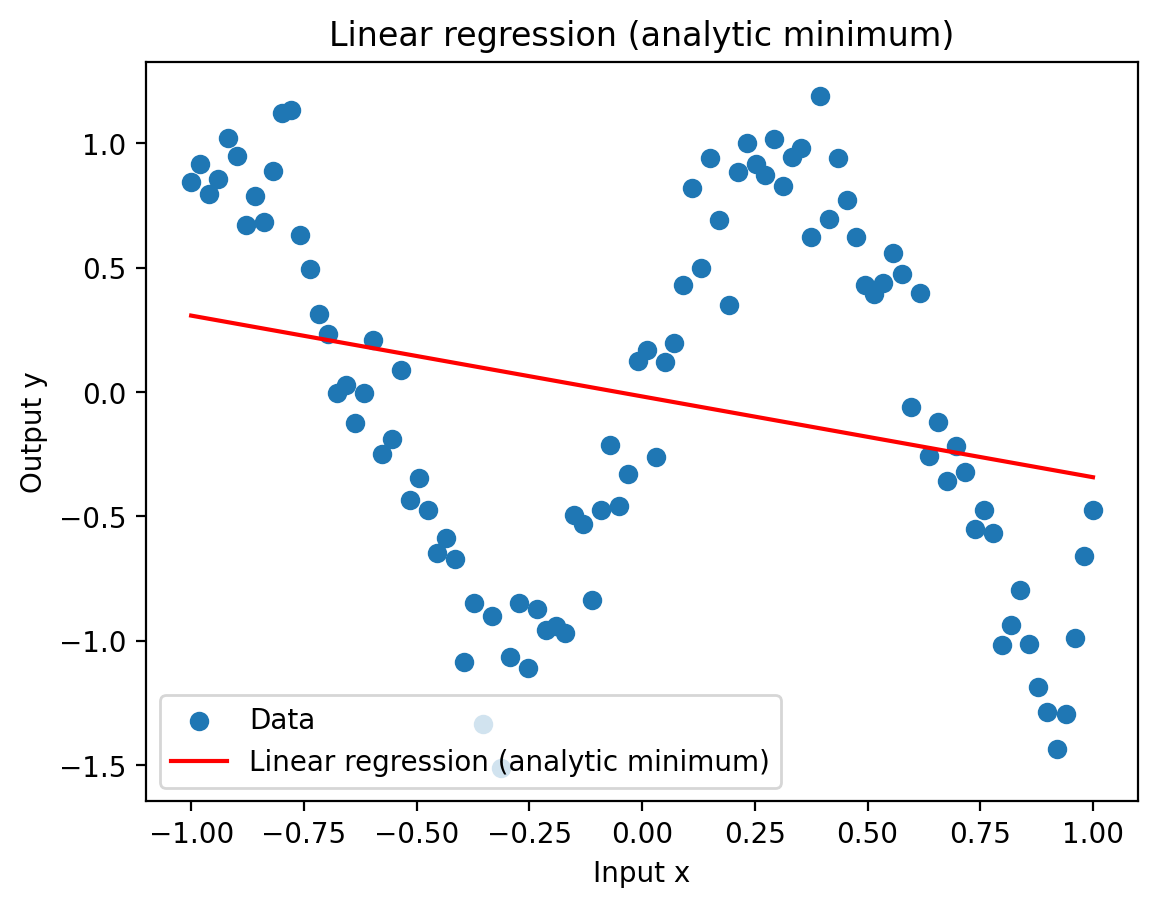

In [22]:
xs, ys = generate_wave_like_dataset()
X = np.vstack([xs, np.ones(len(xs))]).T
w = regression_analytical_solution(X, ys)
y_hat = X.dot(w)

plot_data(y_hat, xs, ys, "Linear regression (analytic minimum)")

In [23]:
def create_data_matrix(xs):
    return np.vstack([np.power(xs, 4), np.power(xs, 3), np.power(xs, 2), xs, np.ones(len(xs))]).T

phi = create_data_matrix(xs)

Step 0: w: [ 0.58907842 -0.5596628  -1.3446858   0.10250429 -0.94223977], Loss: 2.088789701461792, Grad: [-0.6465968   0.18570693 -1.0102385   0.05771925 -2.5190487 ]
Step 500: w: [ 0.86708856 -1.125481   -0.83472985  0.28194192  0.08802203], Loss: 0.3655032217502594, Grad: [ 0.00379152  0.08881059 -0.01293283 -0.05577185  0.00404049]
Step 1000: w: [ 0.8375215  -1.5307078  -0.7824136   0.5417364   0.07517765], Loss: 0.31828492879867554, Grad: [ 0.00719827  0.07406553 -0.00885758 -0.04776014  0.001626  ]
Step 1500: w: [ 0.7994861  -1.8706692  -0.7416183   0.76100105  0.06891382], Loss: 0.28484711050987244, Grad: [ 0.00781348  0.0622416  -0.00767065 -0.04014615  0.00101172]
Step 2000: w: [ 0.7604396  -2.1563764  -0.704589    0.94528425  0.06436293], Loss: 0.2610917091369629, Grad: [ 0.00775641  0.05230917 -0.00719302 -0.03373986  0.00084094]
Step 2500: w: [ 0.7221642  -2.3964906  -0.6694034   1.1001599   0.06033289], Loss: 0.24418126046657562, Grad: [ 0.00754257  0.04396185 -0.00689471 -

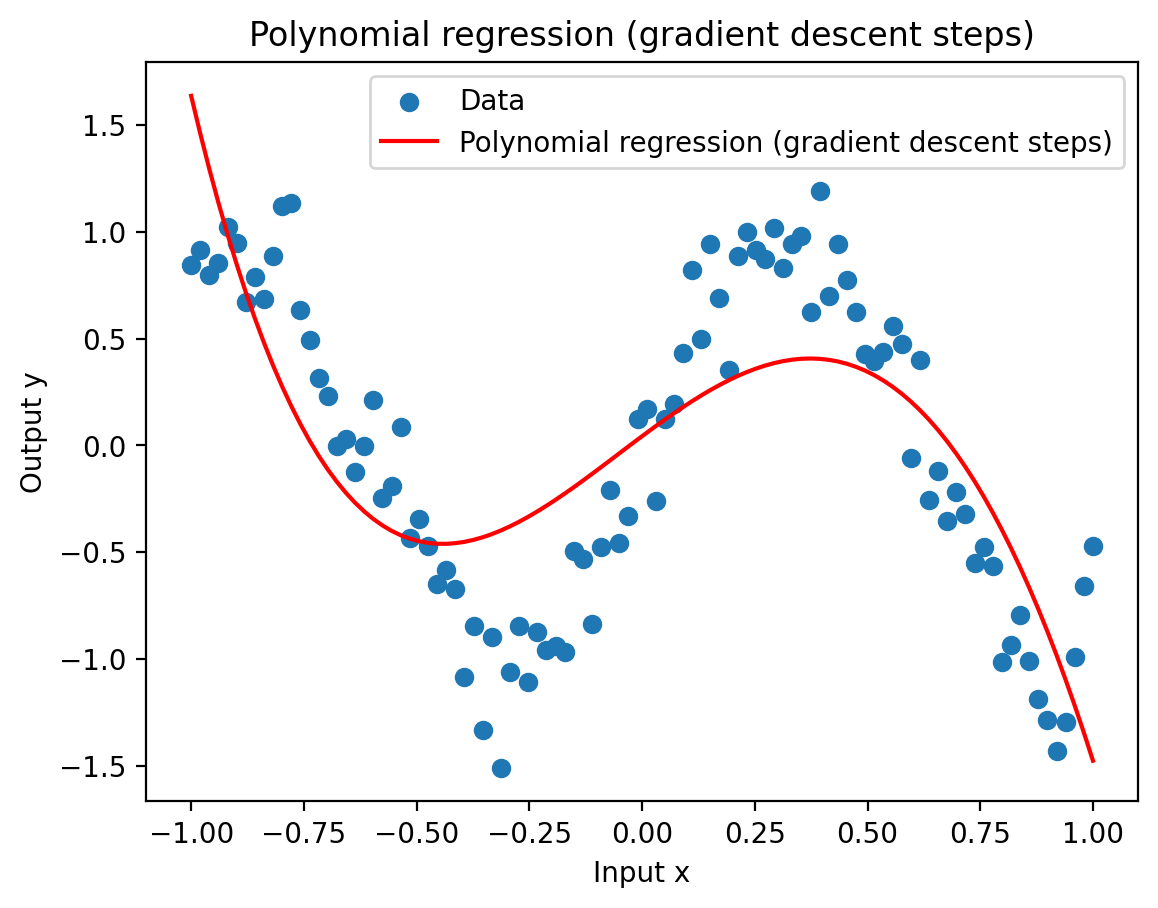

In [24]:
w = gradient_descent(phi, ys, num_steps=5000)
print("w:", w)
y_hat = phi.dot(w)

plot_data(y_hat, xs, ys, 'Polynomial regression (gradient descent steps)')

w: [-0.3651147  -3.66107058  0.31976564  1.91582432 -0.05014023]


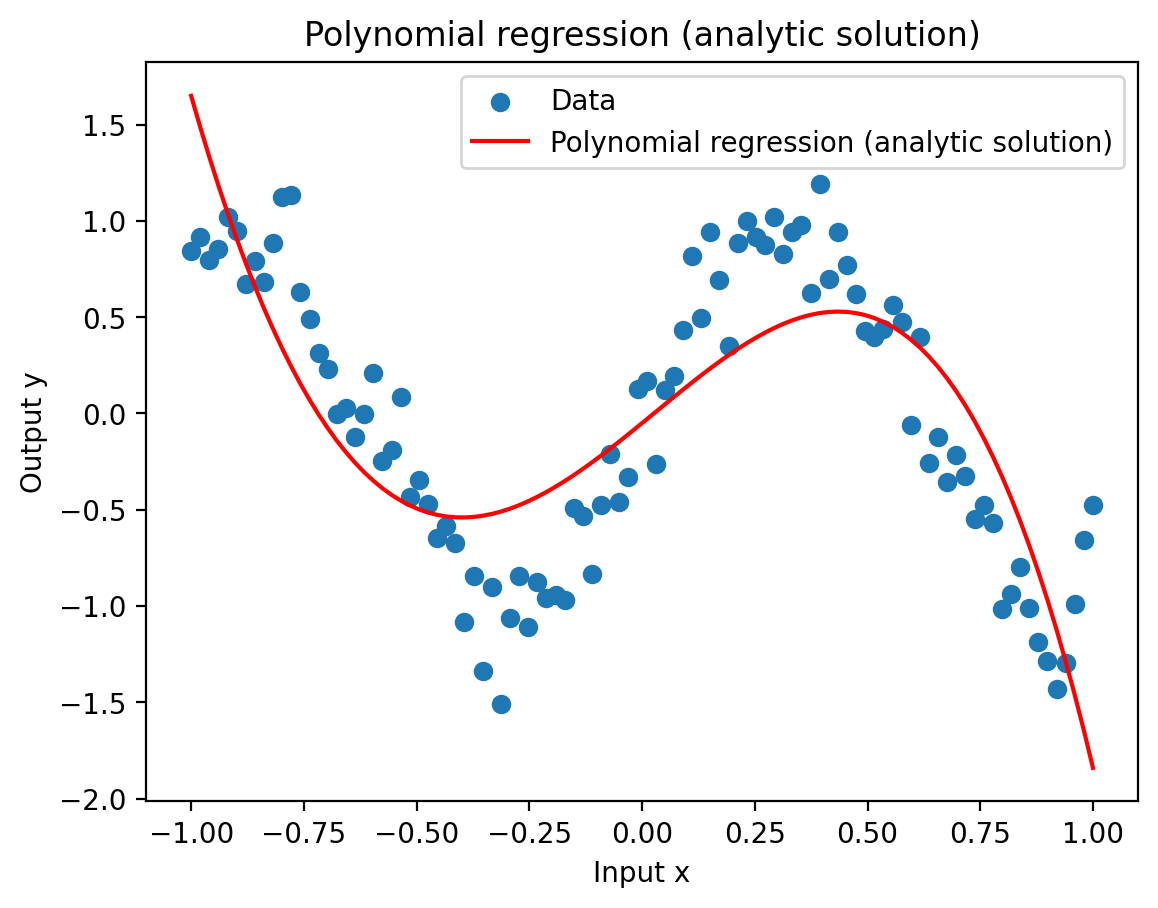

In [25]:
w = regression_analytical_solution(phi, ys)
print("w:", w)
y_hat = phi.dot(w)

plot_data(y_hat, xs, ys, "Polynomial regression (analytic solution)")

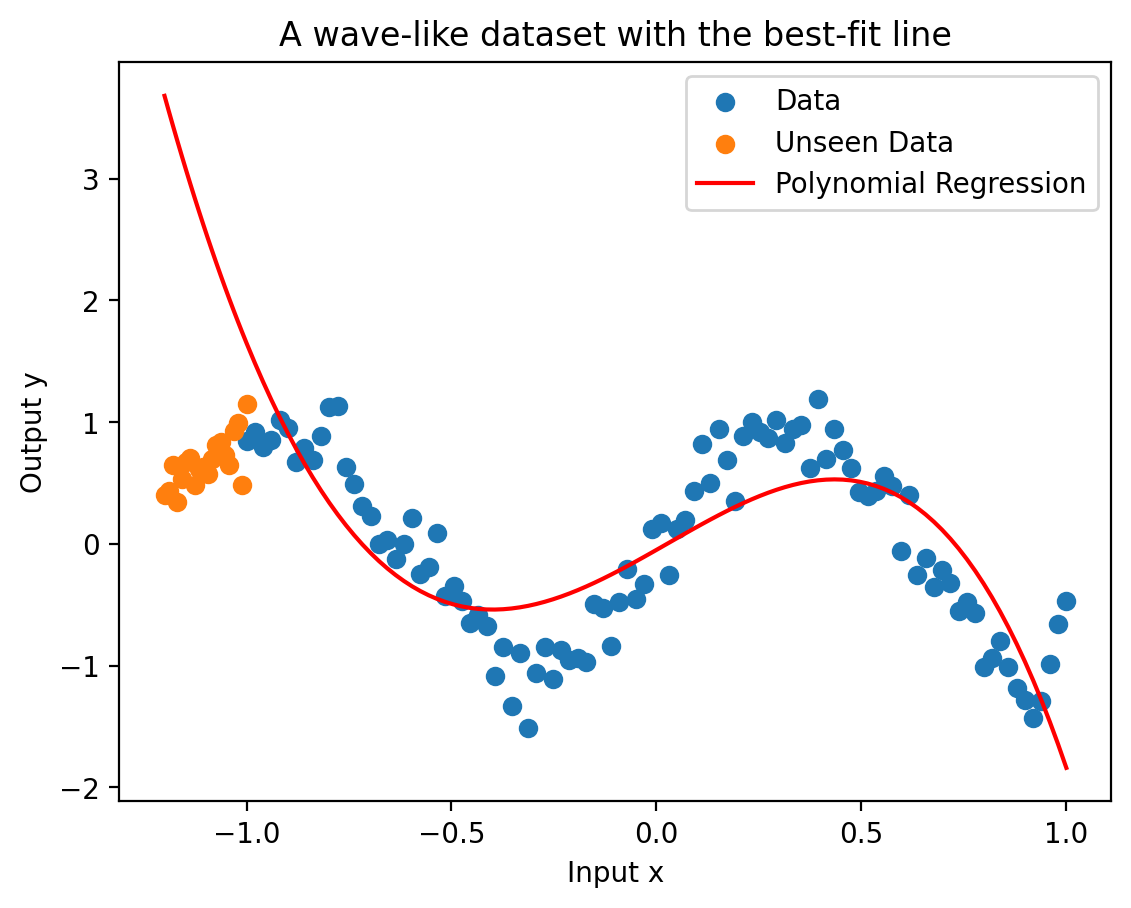

In [26]:
# Recover the analytic solution.
phi = create_data_matrix(xs)
w = regression_analytical_solution(phi, ys)

# Extend the x's and y's.
more_xs, more_ys = generate_wave_like_dataset(min_x=-1.2, max_x=-1, n=20)
all_xs = np.concatenate([more_xs, xs])
all_ys = np.concatenate([more_ys, ys])

# Get the design matrix for the extended data, so that we could make predictions
# for it.
phi = create_data_matrix(all_xs)

# Note that we don't recompute w, we use the previously computed values that
# only saw x values in the range [0, 10]
y_hat = phi.dot(w)

plt.scatter(xs, ys, label="Data")
plt.scatter(more_xs, more_ys, label="Unseen Data")
plt.plot(all_xs, y_hat, 'r', label='Polynomial Regression')

plt.title("A wave-like dataset with the best-fit line")
plt.xlabel("Input x")
plt.ylabel("Output y")
plt.legend()
plt.show()